# Spillover Effects of Mass Shootings

In this notebook, we study the effects of mass shootings on tangential "shooting"-related economies.

The main question is: "**Does demand for shooting activities increase after a mass shooting?**"

Mass shootings are a relatively new phenomenon in human history and are increasing in frequency. Few things are known about their effects on economies. Specifically, while demand for firearms and security increases, overall business tends to decrease. This project focuses on the effects of mass shootings on tangential “shooting”-related economies. One example would be first-person shooter (FPS) games. Do mass shootings serve as a marketing tool or a deterrent to FPS games? We hypothesize that after a mass shooting, demand for shooting-related activities will increase, depending on the number of physical casualties.

To analyze this question, we first use interactive maps to show a basic pattern of mass shooting severity and Counter-Strike popularity in each state. We then use linear regressions to investigate this relationship. Finally, we conduct a dynamic DID analysis and conclude that relatively “small” mass shootings increase Counter-Strike popularity, while relatively “large” mass shootings reduce Counter-Strike popularity.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
from sklearn import (linear_model, metrics, neural_network, pipeline, model_selection)
import seaborn as sns
import geopandas as gpd
from bokeh.plotting import figure, ColumnDataSource
from bokeh.io import output_notebook, show, output_file
from bokeh.models import GeoJSONDataSource, LinearColorMapper, ColorBar, HoverTool
from bokeh.palettes import brewer
import json
import csv
from shapely.geometry import Point
from datetime import timedelta,datetime
from pandas.tseries.offsets import DateOffset
from linearmodels.panel import PanelOLS
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col
%matplotlib inline

### 1 Data
#### 1.1 Data collection
 [Mother Jones’Investigation](https://www.motherjones.com/politics/2012/12/mass-shootings-mother-jones-full-data/) and [Google Trends](https://trends.google.com/home?hl=en-US):
* **Mass shooting data**  
  * Mother Jones - Mass Shootings Database, 1982 - 2023 - Sheet1.csv
* **Counter Strike popularity data**
  * by state: CS_State_Map.xlsx
  * by month: Counter Strike.csv
  * by state and month: CS_panel data.csv
* **Other popularity data**
  * Airsoft popularity: airsoft map.csv
  * Laser Tag popularity: laser tag map.csv
* **Control variables**
  * income information: Income per county.csv

In [2]:
url1 = "Mother Jones - Mass Shootings Database, 1982 - 2023 - Sheet1.csv"
url2 = "Income per county.csv"
url3 = "CS_State_Map.xlsx"
url4 = "Counter Strike.csv"
url5 = "CS_panel data.csv"
url6 = "airsoft map.csv"
url7 = "laser tag map.csv"

# load raw data
shootings = pd.read_csv(url1, encoding='iso-8859-1', parse_dates=["date"])
income = pd.read_csv(url2, encoding='latin-1')
CS = pd.read_excel(url3)
CS_month = pd.read_csv(url4, encoding='iso-8859-1', parse_dates=["Month"])
original_panel_data = pd.read_csv(url5,  parse_dates=["Month"])
airsoft = pd.read_csv(url6, encoding='iso-8859-1')
laser = pd.read_csv(url7, encoding='iso-8859-1')

# data cleaning
# melt the short data frame to long data frame
panel_data = pd.melt(original_panel_data, id_vars='Month', var_name='state', value_name='CS popularity')
panel_data['Month'] = pd.to_datetime(panel_data['Month'], format='%Y-%m-%d')
# get the state information
shootings1 = pd.concat([shootings, shootings["location"].str.split(', ', expand=True)], axis=1).rename(columns={0: "City", 1: "Region"})
MS=shootings1[["date","Region","fatalities"]]
# get the recent Mass Shootings
MS_events=shootings1[["Region","date","fatalities"]]
MS_events=MS_events[(MS_events["date"]>='2010-01-01') & (MS_events["date"]<='2023-07-01')]
#clean the data for regression 1
def cleandata_regression1(dataset,valname,rename):
    final = pd.merge(shootings1, dataset, on="Region").filter(['case','City','Region' ,valname, 'year'], axis=1)
    final["MS"] = final.groupby('Region')['Region'].transform('count')
    X=final.drop(["case", "City", "year"], axis=1).copy()
    X=X.drop_duplicates()
    X[rename]=X[valname]
    return X
X=cleandata_regression1(CS, 'Counter Strike: (1/1/04 - 3/28/23)','CS')

#### 1.2 Data exploration

##### 1.2.1 Interactive maps for Mass Shooting victim number and Counter Strike popularity

In [3]:
states = gpd.read_file('https://www2.census.gov/geo/tiger/GENZ2019/shp/cb_2019_us_state_500k.zip')
states_df = gpd.read_file("https://datascience.quantecon.org/assets/data/cb_2016_us_state_5m.zip")
states_df = states_df.query("NAME != 'United States Virgin Islands'")
states_df = states_df.query("NAME != 'Commonwealth of the Northern Mariana Islands'")
states_df = states_df.query("NAME != 'Alaska'")
states_df = states_df.query("NAME != 'Hawaii'")
state_counts = {}

with open('Mother Jones - Mass Shootings Database, 1982 - 2023 - Sheet1.csv', 'r', encoding='utf-8') as file:
    shootings_reader = csv.reader(file)
    next(shootings_reader)
    for row in shootings_reader:
        state = row[1].split(',')[1].strip() 
        if state == "D.C.":
            state = "District of Columbia"
        if not row[6].isdigit():
            row[6] = row[4]
        try:
            date = datetime.strptime(row[2], "%m/%d/%y")
        except ValueError:
            date = datetime.strptime(row[2], "%m/%d/%Y")
        if date >= datetime(2004, 1, 1):
            count = int(row[6]) 
            state_counts[state] = state_counts.get(state, 0) + count
missing_states = ['New Hampshire', 'Rhode Island', 'Maine', 'Vermont',
                  'South Dakota', 'Wyoming', 'North Dakota', 'West Virginia', 
                  'Montana', 'New Mexico', 'Delaware','Idaho','Louisiana','Utah', 'Arizona', 'Nebraska','Iowa',
                  'Minnesota', 'Kentucky', 'Arkansas', 'Mississippi', 'Massachusetts', 'Connecticut', 'Illinois']
for state in missing_states:
    if state not in state_counts:
        state_counts[state] = 0
df_state_counts = pd.DataFrame({'State': list(state_counts.keys()), 'Count': list(state_counts.values())})
mass_states = states_df.merge(df_state_counts, left_on="NAME",  right_on="State", how="inner")
output_notebook()
states_geojson=GeoJSONDataSource(geojson=mass_states.to_json())
color_mapper = LinearColorMapper(palette = brewer['RdYlBu'][10], low = 0, high = 620)
color_bar = ColorBar(color_mapper=color_mapper, label_standoff=8,width = 760, height = 30,
                     border_line_color=None,location = (0,0), orientation = 'horizontal')
hover = HoverTool(tooltips = [ ('State','@State'),('Total Victims', '@Count')])

p = figure(title="Figure 1. Mass Shootings by Total Victims, 2004 - 2023", tools=[hover], plot_width=850, plot_height=600)
p.patches("xs","ys",source=states_geojson,
          fill_color = {'field' :'Count', 'transform' : color_mapper})
p.add_layout(color_bar, 'below')
show(p)

Loading BokehJS ...

This map shows the total number of victims of mass shootings in each US state from 2004 to 2023.

From the map, we can see that some states stand out as having a higher number of mass shooting victims, such as Nevada (616), Texas (262), California (223), Florida (175), and Colorado (140). Other states, such as New Mexico (0), Mississippi (0), and Iowa (0), have relatively few mass shooting victims. We notice that the number of victims in most states is below 100.

The map is interactive, allowing us to hover over each state and see its name and the total number of victims. This feature can be useful for identifying specific states with high numbers of victims and for comparing the relative number of victims between states.

Overall, this choropleth map provides a clear visualization of the distribution of mass shooting victims across the US.

In [4]:
counter_strike = CS.rename({'Counter Strike: (1/1/04 - 3/28/23)':'cs_popularity'}, axis=1)
cs_w_states = states_df.merge(counter_strike, left_on="NAME",  right_on="Region", how="inner")
output_notebook()
cs_states_geojson=GeoJSONDataSource(geojson=cs_w_states.to_json())
color_mapper = LinearColorMapper(palette = brewer['RdYlBu'][10], low = 0, high = 100)
color_bar = ColorBar(color_mapper=color_mapper, label_standoff=8,width = 780, height = 30,
                     border_line_color=None,location = (0,0), orientation = 'horizontal')
hover = HoverTool(tooltips = [ ('State','@NAME'),('CS popularity', '@cs_popularity')])
p = figure(title="Figure 2. Counter Strike Popularity Map, 2004 - 2023", tools=[hover], plot_width=850, plot_height=600)
p.patches("xs","ys",source=cs_states_geojson,
          fill_color = {'field' :'cs_popularity', 'transform' : color_mapper})
p.add_layout(color_bar, 'below')
show(p)

Loading BokehJS ...

The second plot shows a map of the United States with each state colored according to its level of popularity for the game Counter-Strike (CS) from 2004 to 2023. Similar to the first plot, the states are outlined and labeled with their names. We notice that the most common CS popularity value for most states is approximately 30.

Outlier states include Virginia (100) and California (64).

Comparing the two maps above, we observe that states with a high number of victims partly match with states with high CS popularity. There appears to be a relationship between CS popularity and the number of victims from mass shootings.

##### 1.2.2 scatter plot: Mass Shootings and CS popularity

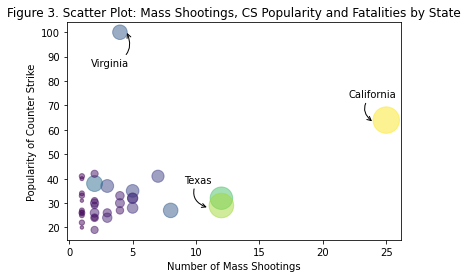

In [13]:
scatter=pd.merge(MS.groupby("Region").sum(),X, on="Region")
fig, ax = plt.subplots()
ax.scatter(scatter["MS"],scatter["CS"], s=scatter["fatalities"]*4, c=scatter["fatalities"], alpha=0.5)
ax.set_xlabel("Number of Mass Shootings")
ax.set_ylabel("Popularity of Counter Strike")
ax.set_title("Figure 3. Scatter Plot: Mass Shootings, CS Popularity and Fatalities by State")

for i, row in scatter[(scatter['Region']=='California') | (scatter['Region']=='Texas')].iterrows():
    ax.annotate(row['Region'], (row['MS']-1, row['CS']-1),xytext=(-25, 25), textcoords="offset points",
    arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=0.6"))
for i, row in scatter[(scatter['Region']=='Virginia') ].iterrows():
    ax.annotate(row['Region'], (row['MS']+0.5, row['CS']+0.5), xytext=(-35, -35), textcoords="offset points",
    arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=0.6"))
plt.show()

This scatter plot shows the relationship between the number of mass shootings (MS) and the popularity of Counter-Strike (CS) in different states. Each point in the plot represents a state, and the size of the point indicates the number of fatalities resulting from mass shootings in that region.

From the scatter plot, we can see that there is a linear relationship between mass shootings and CS popularity. The scatter plot also includes labels for three states: California, Texas, and Virginia, allowing us to easily identify the states with the highest and lowest MS counts and CS popularity.

Overall, the scatter plot shows that there is a positive relationship between the popularity of Counter-Strike and the number of mass shootings in each state. This is evident from the general upward trend of the dots as we move from left to right in the plot. The plot also shows that the number of fatalities in each state varies greatly, with some states having a higher number of fatalities than others.

##### 1.2.3 line graphs: time trends of Mass Shooting event number and CS popularity

C:\Users\lenovo\AppData\Local\Temp\ipykernel_5520\1023738929.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_shootings1['Month'] = pd.to_datetime(merged_shootings1['Month'])


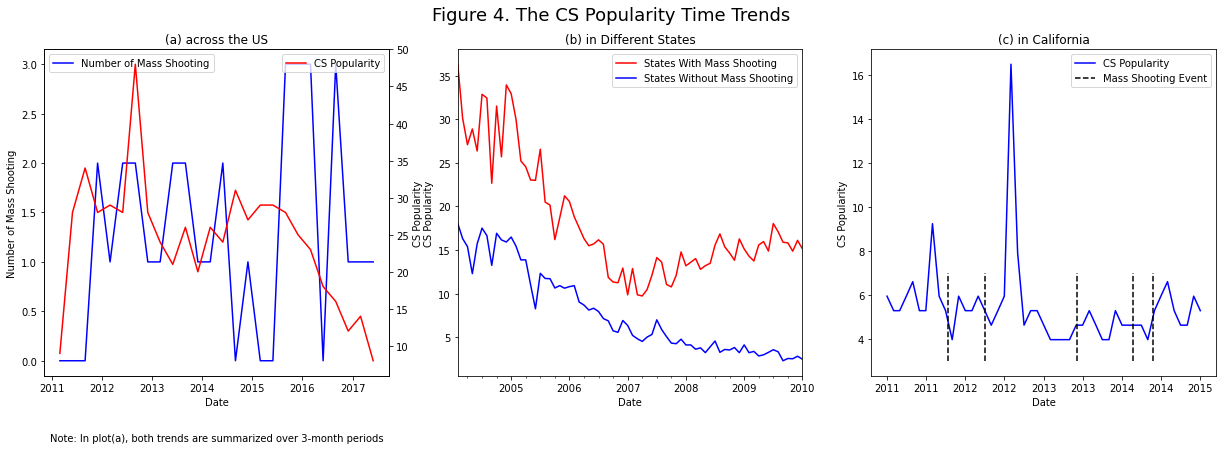

In [14]:
fig, ax = plt.subplots(1,3,figsize=(21, 6))
fig.suptitle('Figure 4. The CS Popularity Time Trends',fontsize=18)
# the first line graph
monthly_shootings = shootings.groupby(pd.Grouper(key='date', freq='M')).count()
monthly_shootings = monthly_shootings.reset_index()
monthly_shootings = monthly_shootings[['date', 'case']]
monthly_shootings = monthly_shootings.rename(columns={'date': 'Month', 'case': 'Number of Incidents'})
monthly_shootings['Month']=monthly_shootings['Month'] + timedelta(days=1) - DateOffset(months=1)
monthly_shootings['Month'] = pd.to_datetime(monthly_shootings['Month'], format='%Y-%m-%d')
CS_month['Month'] = pd.to_datetime(CS_month['Month'], format='%b-%y')
merged_shootings = pd.merge(monthly_shootings, CS_month, on='Month')
merged_shootings1 = merged_shootings.loc[(merged_shootings['Month'] >= '2011-02-01') &  (merged_shootings['Month'] <='2017-04-01')]
merged_shootings1['Month'] = pd.to_datetime(merged_shootings1['Month'])
merged_shootings1.set_index('Month', inplace=True)
merged_shootings2 = merged_shootings1.resample('3M').sum()
merged_shootings2=merged_shootings2.reset_index()
ax[0].plot(merged_shootings2['Month'], merged_shootings2['Number of Incidents'], color='blue', label='Number of Mass Shooting')
ax[0].set_ylabel('Number of Mass Shooting')
ax2 = ax[0].twinx()
ax2.plot(merged_shootings2['Month'], merged_shootings2['counter strike: (United States)'], color='red', label='CS Popularity')
ax2.set_ylabel('CS Popularity')
ax[0].legend(loc='upper left')
ax2.legend(loc='upper right')
ax[0].set_xlabel('Date')
ax[0].set_title('(a) across the US')
plt.annotate('Note: In plot(a), both trends are summarized over 3-month periods', xy=(0.5, -0.2), xycoords='axes fraction', ha='center')

# the second line graph
A=MS_events.groupby("Region")
shootings_data=MS_events.loc[A["fatalities"].idxmax()]
shootings_data=shootings_data[shootings_data["fatalities"]>=10]
merged_data = pd.merge(panel_data, shootings_data, how='left', left_on=['state'],right_on=['Region'])
merged_data['treatment'] = np.where(merged_data['date'].notnull(), 1, 0)  # define treatment group and control group
merged_data = merged_data.rename(columns={'CS popularity': 'CS_popularity'})
plot_trends=merged_data[merged_data['Month']<='2010-01-01']
plot_trends.query('treatment == 1').groupby('Month')['CS_popularity'].mean().\
plot(ax=ax[1], color='red', label='States With Mass Shooting')# treatment group
plot_trends.query('treatment == 0').groupby('Month')['CS_popularity'].mean().\
plot(ax=ax[1], color='blue', label='States Without Mass Shooting')# control group
ax[1].set_xlabel('Date')
ax[1].set_ylabel('CS Popularity')
ax[1].set_title('(b) in Different States')
ax[1].legend()

# the third line graph
California_MS=shootings1[shootings1["Region"]=='California']['date']
California_MS=California_MS[(California_MS>='2011-01-01') & (California_MS<='2015-01-01')]
California_CS=merged_data[merged_data["state"]=='California']
California_CS=California_CS[(California_CS["Month"]>='2011-01-01') & (California_CS["Month"]<='2015-01-01')]
ax[2].plot(California_CS['Month'], 
        California_CS['CS_popularity'], color='blue')
lines = []
for x in list(California_MS):
    line = ax[2].vlines(x, 3, 7, colors='black', linestyles='dashed')
    lines.append(line)
ax[2].legend([ax[2].lines[0], lines[1]], ['CS Popularity', 'Mass Shooting Event'])
ax[2].set_xlabel('Date')
ax[2].set_ylabel('CS Popularity')
ax[2].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:.0f}'.format(mdates.num2date(x).year)))
ax[2].set_title('(c) in California')
plt.show()

This section presents three line graphs depicting the relationship between CS popularity and mass shootings across three distinct levels: a general level, a state level, and a specific event level.

- **Plot (a)** shows the trends of CS popularity and mass shooting numbers across the US. We notice that, in general, the rise of CS popularity (red) coincides with the increase in the number of mass shooting events (blue).

- **Plot (b)** shows the trends of CS popularity for states with mass shootings and states without mass shootings. Visually, we see that states with mass shootings (red) seem to have consistently higher Counter-Strike popularity compared to states without mass shootings (blue). This gap has continued to increase since 2007, suggesting a correlation between mass shootings and Counter-Strike popularity.

- **Plot (c)** shows the change in CS popularity after mass shooting events in California. The dates of mass shooting events in California are marked with dashed lines. We notice that CS popularity rises after each mass shooting event.

Sure, here is the corrected version with improved grammar and typo corrections:

### 2 Preliminary Data Analysis
In this step, we identify correlations or relationships between variables. We conduct preliminary data analysis, such as simple linear regression, to assess the feasibility of examining causality with the available data.

#### 2.1 Simple Linear Regression
##### 2.1.1 MS Number and CS Popularity
Firstly, we examine the correlation by:

$$CS_i = \beta_0 + \beta_1 \cdot totalMS_i + \epsilon \quad \quad \quad \text{(1)}$$ 

where:
   * \(i\) denotes the state;
   * \(CS_i\) denotes the total Counter-Strike popularity for state \(i\);
   * \(totalMS_i\) denotes the total number of mass shooting events in state \(i\);
   * \(\epsilon\) is the error term.

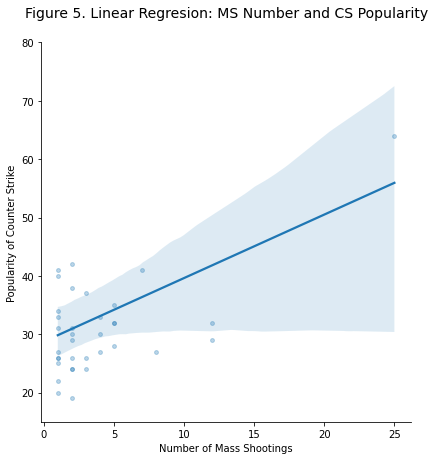

In [15]:
g1=sns.lmplot(data=cleandata_regression1(CS,'Counter Strike: (1/1/04 - 3/28/23)','CS'), x="MS", y="CS", height=6,
    scatter_kws=dict(s=15, alpha=0.3))
g1.set_axis_labels("Number of Mass Shootings", "Popularity of Counter Strike")
plt.title('Figure 5. Linear Regresion: MS Number and CS Popularity',y=1.05,fontsize=14)
plt.ylim(15,80)
plt.show()

The code generates a scatterplot with a regression line depicting the relationship between the number of mass shootings and the popularity of Counter-Strike across the US from January 1, 2004, to March 28, 2023. The scatterplot shows the distribution of the data points, where each point represents a specific combination of mass shooting numbers and Counter-Strike popularity. The regression line represents the best fit line through the data points, indicating the direction and strength of the relationship between the two variables.

The results suggest that as the number of mass shootings increases, the popularity of Counter-Strike also tends to increase.

In [8]:
shootings_lr_model = linear_model.LinearRegression()
shootings_lr_model.fit(X[["MS"]], X["CS"])
beta_0 = shootings_lr_model.intercept_ # get the coefficients
beta_1 = shootings_lr_model.coef_[0]
model1 = smf.ols(formula='CS~ MS', data=X)
result = model1.fit(cov_type='HC3') 
print(result.summary())
print(f"Counter Strike Popularity= {beta_0:.4f} + {beta_1:.4f} Number of Mass Shootings")

                            OLS Regression Results                            
Dep. Variable:                     CS   R-squared:                       0.125
Model:                            OLS   Adj. R-squared:                  0.100
Method:                 Least Squares   F-statistic:                     2.537
Date:                Mon, 24 Apr 2023   Prob (F-statistic):              0.120
Time:                        19:32:50   Log-Likelihood:                -143.37
No. Observations:                  36   AIC:                             290.7
Df Residuals:                      34   BIC:                             293.9
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     28.7469      2.943      9.766      0.0

The regression equation is: Counter Strike Popularity = 28.7469 + 1.0878 × Number of Mass Shootings.

The linear regression model shows that the number of mass shootings is positively and significantly associated with the popularity of the Counter Strike (CS) video game (β = 1.0878, p < 0.2). This means that for every one-unit increase in the number of mass shootings, the popularity of CS increases by an average of 1.0878 units.

##### 2.1.2 MS Number and Popularity of Airsoft and Laser Tag
To examine whether MS has a similar effect on other activities such as airsoft and laser tag, we conduct the regression below, which is similar to regression (1).

$$Y_i=\beta_0 + \beta_1 \text{totalMS}_i + \epsilon \quad \quad \quad \text{(2)}$$

where \(Y_i\) denotes the total airsoft or laser tag popularity for state \(i\) and other variables are the same as those in regression (1).

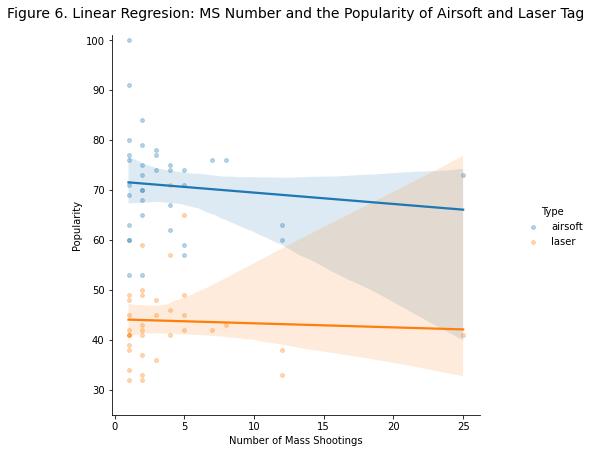

In [16]:
# data cleaning: merge 'airsoft' and 'laser' columns into one column 'value'
d1=cleandata_regression1(airsoft,'airsoft: (2004/1/1 - 2023/4/10)','airsoft')
d2=cleandata_regression1(laser,'laser tag: (2004/1/1 - 2023/4/10)','laser')                       
combined=pd.merge(d1,d2,on=["Region","MS"])
combine = pd.melt(combined, id_vars=['MS'], value_vars=['airsoft', 'laser'], var_name='Type', value_name='value')

# create the lmplot
g2 = sns.lmplot(data=combine,
                x='MS', y='value', hue='Type', height=6,
                scatter_kws=dict(s=15, alpha=0.3))
g2.set_xlabels('Number of Mass Shootings')
g2.set_ylabels('Popularity')
plt.title('Figure 6. Linear Regresion: MS Number and the Popularity of Airsoft and Laser Tag',y=1.03,fontsize=14)
plt.ylim(25,101)
plt.show()

The regression line slopes for both types are small and show no significant correlation between the number of mass shootings and the popularity of airsoft or laser tag. 
Therefore, we will continue to use CS popularity data to examine the effect.

#### 2.2 Linear regression: MS number and the change of CS popularity
Secondly, we examine the correlation by

$$\begin{alignat*}{9}
& \Delta CS_{it+1}=\beta_0 + \beta_1 MS_{it}+\epsilon &  &\quad\text{(3)} \\
& \Delta CS_{it+1}=\beta_0 + \beta_1 MS_{it}+\gamma_i+\epsilon&  &\quad\text{(4)}\\
& \Delta CS_{it+1}=\beta_0 + \beta_1 MS_{it}+\beta_2 Fat_{it}+\epsilon&  &\quad\text{(5)}\\
& \Delta CS_{it+1}=\beta_0 + \beta_1 MS_{it}+\beta_2 Fat_{it}+\gamma_i+\epsilon&  &\quad\text{(6)}\\
\end{alignat*}$$

where:
  * i denotes state, t denotes the date,$\gamma_i$ denotes state fixed effect;
  * $\Delta CS_{it+1}= CS_{it+1}-CS_{it}$ denotes the Counter Strike popularity for state i in month t+1 minus the Counter Strike popularity for state i in month t, namely the change of Counter Strike popularity for state i; 
  * $MS_{it}$ is a dummy variable, which equals 1 when there is at least 1 Mass Shooting events for state i in month t and equals 0 otherwise; 
  * $Fat_{it}$ is the fatalities during Mass Shooting for state i in month t; 
  * $\epsilon$ is the error term.

Regression(5) and (6) take fatalities, namely the intensity of Mass Shooting into consideration.\
Regression(4) and (6) take state fixed effects into consideration.

In [10]:
#cleaning data
MS['date'] = pd.to_datetime(MS['date']) # get the Mass Shooting date for each state
panel_data["CSdiff"]=panel_data["CS popularity"].shift(-1) - panel_data["CS popularity"] # generate the change of CS
panel_data=panel_data[panel_data["Month"]!='2004-01-01']
merged = pd.merge(panel_data, MS, left_on='state',right_on='Region')
merged["time_diff"]=merged["Month"]-merged["date"]
merged["shooting"]=np.where(((merged['time_diff'].dt.days >= 0) & (merged['time_diff'].dt.days <= 30)) , 1, 0) #generate I[MS>=1]
merged["fatality"]=merged["fatalities"]*merged["shooting"]# generate fatality number

#run regression
res_ols1 = smf.ols(formula='CSdiff~shooting', data=merged).fit(cov_type='HC3') #regression(2)
res_ols2 = smf.ols(formula='CSdiff~shooting+state', data=merged).fit(cov_type='HC3') #regression(3)
res_ols3 = smf.ols(formula='CSdiff~shooting+fatality', data=merged).fit(cov_type='HC3') #regression(4)
res_ols4 = smf.ols(formula='CSdiff~shooting+fatality+state', data=merged).fit(cov_type='HC3') #regression(5)
drop_vars = [var for var in res_ols2.model.exog_names if var.startswith('state')]

def fixed_effects_indicator(model):
    if any(param.startswith('state') for param in model.params.index):
        return 'Yes'
    else:
        return 'No'
print(summary_col([res_ols1,res_ols2,res_ols3,res_ols4],
             model_names = ['(1)','(2)','(3)','(4)'],
             stars = True,regressor_order = ['shooting','fatality'],
             drop_omitted = drop_vars,
             info_dict={'Fixed Effects': fixed_effects_indicator,
                        '': lambda x: '',
                        'Observation': lambda x: str(int(x.nobs))}))

C:\Users\lenovo\AppData\Local\Temp\ipykernel_5520\3287299495.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MS['date'] = pd.to_datetime(MS['date']) # get the Mass Shooting date for each state



                 (1)      (2)      (3)      (4)   
--------------------------------------------------
shooting       0.5474*  0.5509*  0.8553*  0.8511* 
               (0.3179) (0.3180) (0.4606) (0.4616)
fatality                         -0.0393  -0.0383 
                                 (0.0284) (0.0289)
R-squared      0.0001   0.0003   0.0001   0.0003  
R-squared Adj. 0.0000   -0.0009  0.0000   -0.0009 
Fixed Effects  No       Yes      No       Yes     
                                                  
Observation    31738    31738    31738    31738   
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


From the regression results, we know that there is a positive relationship between mass shootings and CS popularity changes. The coefficient is even larger when fatalities are included. The inclusion of state fixed effects in the regression models controls for state-level heterogeneity and provides more robust estimates of the relationship between mass shootings and CS popularity.

Interestingly, fatalities have a negative effect on CS popularity. One possible explanation is that high fatalities negatively affect the morale of players such that demand for Counter-Strike decreases. This effect, however, is insignificant and small compared with the positive effect of mass shootings on CS popularity. Take the results from column (4) as an example: if there is a mass shooting with 10 fatalities, the effect on CS popularity will be $(0.8511 - 0.0383 \times 10 = 0.4681)$, which means CS popularity will still increase by 0.4681 on average.

Overall, the regression results suggest that mass shootings have a positive impact on the popularity of CS.

### 3 Difference-in-differences (DID) analysis
In this step, we identify the causality of Mass Shooting on CS popularity change using DID strategy.
$$CS_{it}=\sum_{\tau=-4}^{5}\beta_\tau MS_{i} \times Date_t^\tau + \delta_i+\sigma_t+\epsilon_{it} \quad  \text{(7)}$$

where:
  * i denotes state, t denotes the month;
  * $\delta_i$ denotes state fixed effect and $\sigma_t$ denotes time effect;
  * $CS_{it}$ denotes the Counter Strike popularity for state i in month t; 
  * $MS_{i}$ is a dummy variable, which equals 1 when there is at least 1 Mass Shooting events for state i (which means state i is in the treatment group) and equals 0 otherwise; 
  * $Date_{t}^\tau$ is a dummy variable that equals one for the $\tau$ months relative to the Mass Shooting month; 
  * $\epsilon$ is the error term.

We interact the treatment variable with each of the month fixed effects (relative to the treatment month), treating the states that never experience Mass Shootings as the reference group. The estimated vectors of $\beta_\tau$ reveal the differences between the 
treated and control counties during each month. If, for example, Mass Shootings increases CS popularity, then we would expect the estimated $\beta_\tau$ to be constant over time for years before a Mass Shooting happened because of the parallel trends assumption. We would also expect the coefficients to increase if a Mass Shooting happened.

In [11]:
def DID_regression(MS_data):
    merged_data = pd.merge(panel_data, MS_data, how='left', left_on=['state'],right_on=['Region'])
    data = merged_data.rename(columns={'CS popularity': 'CS_popularity'})
    data['time_diff'] = data['Month']-data['date']
    data1 = data[((data['time_diff'].dt.days >= -120) & (data['time_diff'].dt.days <= 180)) | (data['time_diff'].isna())]
    data1['months_diff'] = np.floor_divide(data1['time_diff'].dt.days, 30) ## change it into months difference
    df_filtered = data1.loc[~data1['time_diff'].isna()]# extract rows where time_diff is not NaT
    data1 = data1[data1['Month'].isin(df_filtered['Month'].unique())]# extract all rows that contain Month values in the filtered DataFrame
    dummies = pd.get_dummies(data1['months_diff'], prefix='p', prefix_sep='')# Create dummy variables for the 'months_diff' column
    new_names = {old_name: f'p_{i+1}' for i, old_name in enumerate(dummies.columns)}# Rename the dummy variables
    dummies = dummies.rename(columns=new_names)
    data2 = pd.concat([data1, dummies], axis=1)
    formula = 'CS_popularity ~ Month + state + p_1 + p_2 + p_3 + p_4 + C(p_5, Treatment(1)) + p_6 + p_7 + p_8 + p_9 + p_10'
    # Note that p_5 means the time of mass shooting.
    model = smf.ols(formula=formula, data=data2)
    result = model.fit(cov_type='HC3')
    params = result.params    # extract coefficients
    conf_int = result.conf_int() # extract confidential intervals
    return params,conf_int

Furthermore, we expect that different types of Mass Shootings may affect people differently. Section 2.2 shows, fatalities have a negative effect on CS popularity.Therefore, we define Mass Shootings with **fatalities between 10 and 25** as **medium** Mass Shootings and define those with **more than 25 fatalities** as **large** Mass Shootings. We use the two treatments respectively in regression(7) to investigate the effect of these two MS types on CS popularity.

C:\Users\lenovo\AppData\Local\Temp\ipykernel_5520\3029390220.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1['months_diff'] = np.floor_divide(data1['time_diff'].dt.days, 30) ## change it into months difference
C:\Users\lenovo\AppData\Local\Temp\ipykernel_5520\3029390220.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1['months_diff'] = np.floor_divide(data1['time_diff'].dt.days, 30) ## change it into months difference


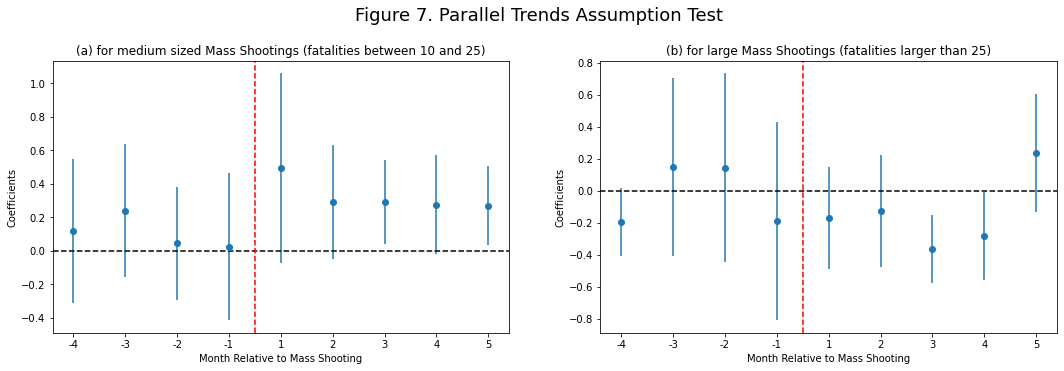

In [12]:
MS_medium=MS_events[(MS_events["fatalities"]>=10) & (MS_events["fatalities"]<=25)]
MS_large=MS_events[MS_events["fatalities"]>25]
params1,conf_int1=DID_regression(MS_medium)
params2,conf_int2=DID_regression(MS_large)

# draw parellel trends plot
fig, ax = plt.subplots(1,2,figsize=(18,5))
fig.suptitle('Figure 7. Parallel Trends Assumption Test',fontsize=18,y=1.03)
ax[0].errorbar(x=params1[-9:].index, y=params1[-9:].values, 
               yerr=(params1[-9:].values - conf_int1[-9:].loc[:,0],
                     conf_int1[-9:].loc[:,1] -params1[-9:].values), fmt='o')
ax[0].axhline(y=0, linestyle='--', color='black')
ax[0].axvline(x=3.5, linestyle='--', color='red')
ax[0].set_xticks(np.arange(len(params1[-9:])))
ax[0].set_xticklabels(['-4','-3','-2','-1','1','2','3','4','5'])
ax[0].set_ylabel('Coefficients')
ax[0].set_xlabel('Month Relative to Mass Shooting')
ax[0].set_title('(a) for medium sized Mass Shootings (fatalities between 10 and 25)')
ax[1].errorbar(x=params2[-9:].index, y=params2[-9:].values, 
               yerr=(params2[-9:].values - conf_int2[-9:].loc[:,0],
                     conf_int2[-9:].loc[:,1] -params2[-9:].values), fmt='o')
ax[1].axhline(y=0, linestyle='--', color='black')
ax[1].axvline(x=3.5, linestyle='--', color='red')
ax[1].set_xticks(np.arange(len(params2[-9:])))
ax[1].set_xticklabels(['-4','-3','-2','-1','1','2','3','4','5'])
ax[1].set_ylabel('Coefficients')
ax[1].set_xlabel('Month Relative to Mass Shooting')
ax[1].set_title('(b) for large Mass Shootings (fatalities larger than 25)')
plt.show()

From Figure 7, we first notice that the parallel trends assumptions are met since $\beta_\tau$ is insignificant for $\tau \in \{-4, -3, -2, -1\}$. Also, for medium-sized mass shootings, we observe that after the treatment, $\beta_\tau$ increases and becomes significantly positive in months 3 and 5, indicating that medium-sized mass shootings increase CS popularity.

Interestingly, for large mass shootings, we observe that after the treatment, $\beta_\tau$ decreases and becomes significantly negative in month 3, indicating that large mass shootings decrease CS popularity.

This phenomenon can be explained by the intuition that medium-sized mass shootings inspire players to play shooting video games, while large mass shootings discourages players. Another explanation could be that medium-sized mass shootings receive less intense media coverage. As a result, the negative connotations of a mass shooting are not sufficiently conveyed to the public.

### 4. Conclusion

We start by observing the total number of mass shootings and Counter-Strike popularity through **two maps** and a **scatter plot**, finding that states with a high number of mass shootings partly match those with high CS popularity. We then propose that there is a causality between mass shootings and CS popularity.We also perform a time series analysis using line graphs. We graph mass shootings against CS popularity, comparing states with mass shootings to those without, while also considering the dates of mass shooting events. This analysis provides evidence supporting our hypothesis. Next, we examine the correlation through some **preliminary linear regressions**. These regressions indicate that the coefficients of interest are significantly positive, suggesting a correlation. For further study, we also analyze "similar" shooting activities, namely airsoft and laser tag, by running preliminary linear regressions. We conclude that there is no correlation between mass shootings and either laser tag or airsoft. However, it is insufficient to conclude that causality exists. Therefore, we conduct **dynamic difference-in-differences** analysis. We find different effects for different types of mass shootings. The results show that medium-sized mass shootings increase CS popularity, while large mass shootings decrease it. In conclusion, medium-sized mass shootings have a positive effect on Counter-Strike popularity.

### 5. Future Study

Future work can explore more variables that could affect the popularity of Counter-Strike, such as new game releases, changes in game features, and promotional events. Additionally, the analysis can be extended to include other popular first-person shooter games to compare trends in popularity over time. It may also be interesting to analyze the effects of online reviews and ratings on the game's popularity. Furthermore, the study can be replicated in different countries to determine if there are regional differences in the factors influencing the game's popularity. Moreover, this analysis only examined short-term effects in the 5-6 months following a mass shooting. Future work could explore whether these effects persist over longer periods and whether there are longer-term consequences for CS popularity and the video game industry as a whole. Lastly, given the study's limitations, future work could consider alternative models or econometric techniques to address potential issues of omitted variable bias and endogeneity.